In [8]:
from collections import Counter
from os import cpu_count

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from pytorch_lightning import seed_everything
from sklearn.cluster import DBSCAN
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.efficientnet import EfficientNet, tf_efficientnet_b8
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm.auto import tqdm
from umap import UMAP
import cv2

from utils import pca_explained_variance_ratio
from metric import getMetric

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model: EfficientNet = tf_efficientnet_b8(pretrained=True)

    @torch.no_grad()
    def forward(self, x):
        x = self.model.forward_features(x)
        x = self.model.global_pool(x)
        return x


class MyDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform: T.Compose):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path_img'])
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.df)


def get_loader():
    return DataLoader(
        dataset=MyDataset(
            df,
            transform=T.Compose([
                T.Resize(672),
                T.CenterCrop(int(672 * 0.954)),
                T.ToTensor(),
                T.Normalize(
                    mean=IMAGENET_DEFAULT_MEAN,
                    std=IMAGENET_DEFAULT_STD,
                ),
            ])
        ),
        batch_size=16,
        num_workers=cpu_count() - 1,
        pin_memory=True,
        shuffle=False,
    )


def extract_feature(model: nn.Module, loader: DataLoader) -> np.ndarray:
    return np.concatenate([
        model.forward(x.cuda()).cpu().numpy()
        for x in tqdm(loader)
    ])

In [3]:
seed = 1
seed_everything(seed)

Global seed set to 1


1

In [4]:
df = pd.read_csv('dataset/train_mod.csv')
# df = df.drop_duplicates(subset=['md5_img'])
df.shape

(34250, 8)

In [ ]:
tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
df['target'] = df.label_group.map(tmp)

In [5]:
df.head()

,posting_id,image,image_phash,title,label_group,id,path_img,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,129225211,dataset/train_images/0000a68812bc7e98c42888dfb...,['train_129225211' 'train_2278313361']
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,3386243561,dataset/train_images/00039780dfc94d01db8676fe7...,['train_3386243561' 'train_3423213080']
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,2288590299,dataset/train_images/000a190fdd715a2a36faed16e...,['train_2288590299' 'train_3803689425']
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,2406599165,dataset/train_images/00117e4fc239b1b641ff08340...,['train_2406599165' 'train_3342059966']
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,3369186413,dataset/train_images/00136d1cf4edede0203f32f05...,['train_3369186413' 'train_921438619']


In [5]:
model = MyModel().eval().cuda()
loader = get_loader()

In [6]:
# feats = extract_feature(model, loader)
# joblib.dump(feats, 'tmp/tf_efficientnet_b8_feats.joblib')

feats = joblib.load('tmp/tf_efficientnet_b8_feats.joblib')
feats.shape

  0%|          | 0/2141 [00:00<?, ?it/s]

(34250, 2816)

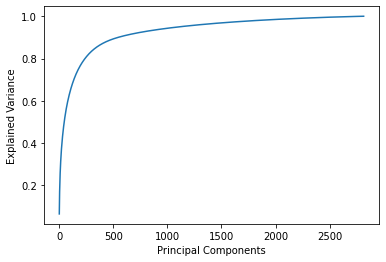

In [7]:
explained_var = pca_explained_variance_ratio(feats)

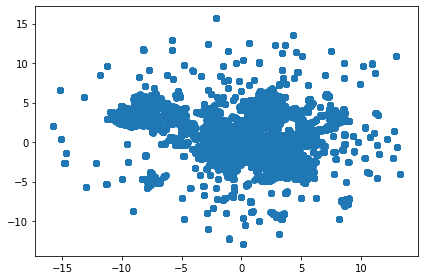

In [15]:
# reduced_2 = UMAP(n_components=2, random_state=seed, transform_seed=seed).fit_transform(feats)
# joblib.dump(reduced_2, 'tmp/tf_efficientnet_b8_reduced_2.joblib')

reduced_2 = joblib.load('tmp/tf_efficientnet_b8_reduced_2.joblib')
plt.scatter(reduced_2[:, 0], reduced_2[:, 1])
plt.tight_layout()
plt.show()

In [13]:
# reduced_400 = UMAP(n_components=400, random_state=seed, transform_seed=seed).fit_transform(feats)
# joblib.dump(reduced_400, 'tmp/tf_efficientnet_b8_reduced_400.joblib')

reduced_400 = joblib.load('tmp/tf_efficientnet_b8_reduced_400.joblib')
reduced_400.shape

(34250, 400)

<ipython-input-16-96c5838ff946>:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


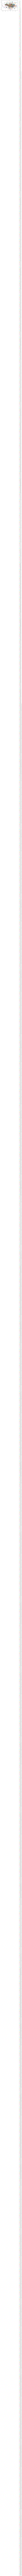

In [16]:
labels = DBSCAN(eps=0.05, min_samples=2, n_jobs=-1).fit_predict(reduced_400)
uniq_labels = list(sorted(set(labels)))

# print(Counter(labels))

for label in uniq_labels:
    mask = (labels == label)
    plt.scatter(reduced_2[mask, 0], reduced_2[mask, 1])
plt.legend(uniq_labels, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [17]:
len(uniq_labels)

3666

In [18]:
df['labels'] = labels

In [19]:
tmp = df.groupby('labels').posting_id.agg('unique').to_dict()
df['oof'] = df.labels.map(tmp)

In [20]:
def outlier_group(row):
    if row.labels == -1:
        return [row.posting_id]
    else:
        return row.oof
df['oof'] = df.apply(outlier_group, axis=1)

In [21]:
df['f1'] = df.apply(getMetric('oof'), axis=1)
print('CV score =', df.f1.mean())

CV score for baseline = 0.5096571433091095
